In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from tqdm import tqdm

warnings.filterwarnings("ignore")

from notebooks.utils import *

## Loading

In [3]:
MOLSTRAL_PATH = Path("MolGenOutput/test_ood")
FIG_PATH = "MolGenDocking-latex/Figures/Results/MolGen"
os.makedirs(FIG_PATH, exist_ok=True)

files = [f for d in MOLSTRAL_PATH.iterdir() for f in d.iterdir() if "error" not in str(f) and str(f).endswith("scored.jsonl")]
files = sorted(files)

print("Total files:", len(files))
df = load_molgen_results(files[:])


sub_sample_prompts = df[df.model == "MiniMax-M2_"].prompt_id.unique()[:]
df = df[df.prompt_id.isin(sub_sample_prompts)]

sub_sample_prompts = df[df.model == "Qwen3-Next-80B-A3B-Thinking_"].prompt_id.unique()[:]
df = df[df.prompt_id.isin(sub_sample_prompts)]

Total files: 104


100%|██████████| 104/104 [01:03<00:00,  1.63it/s]


In [4]:
df.model.unique()

array(['ChemDFM-R-14B_', 'ChemDFM-v2.0-14B_',
       'DeepSeek-R1-Distill-Llama-70B_', 'DeepSeek-R1-Distill-Qwen-32B_',
       'Llama-3.3-70B-Instruct_', 'MiniMax-M2_',
       'Qwen3-30B-A3B-Thinking-2507_', 'Qwen3-Next-80B-A3B-Thinking_',
       'RL-Mistral-24B_', 'ether0_', 'gemma-3-27b-it_', 'gpt-oss-120b_'],
      dtype=object)

In [5]:
sub_sample_prompts = df[df.model == "RL-Mistral-24B_"].prompt_id.unique()[:]
df = df[df.prompt_id.isin(sub_sample_prompts)]

In [6]:
df

,prompt_id,reward,model,n_props,properties,objectives,smiles,validity,valid,Model
0,334810,0.559500,ChemDFM-R-14B_,1,sample_6168_model_0,minimize,CC(C)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=...,1,valid,ChemDFM-R
1,334810,0.000000,ChemDFM-R-14B_,1,sample_6168_model_0,minimize,CC(C)(O)CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP...,1,valid,ChemDFM-R
2,334810,0.310750,ChemDFM-R-14B_,1,sample_6168_model_0,minimize,CC(C)(O)CC[C@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C...,1,valid,ChemDFM-R
3,334810,0.813750,ChemDFM-R-14B_,1,sample_6168_model_0,minimize,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C...,1,valid,ChemDFM-R
4,334810,0.000000,ChemDFM-R-14B_,1,sample_6168_model_0,minimize,,0,no valid SMILES,ChemDFM-R
...,...,...,...,...,...,...,...,...,...,...
1496312,187910390723391000,0.592879,gpt-oss-120b_,3,"sample_582586_model_0,CalcNumHBA,QED","minimize,maximize,above",Cc1ncnc2c1cc(cc2)N3CCOCC3,1,valid,gpt-oss
1496313,187910390723391000,0.584901,gpt-oss-120b_,3,"sample_582586_model_0,CalcNumHBA,QED","minimize,maximize,above",O=C(Nc1ccc(cc1)Cl)C2=CN=C(NC3=CC=CC=C3Cl)N2,1,valid,gpt-oss
1496314,187910390723391000,0.000000,gpt-oss-120b_,3,"sample_582586_model_0,CalcNumHBA,QED","minimize,maximize,above",,0,no valid SMILES,gpt-oss
1496315,187910390723391000,0.629792,gpt-oss-120b_,3,"sample_582586_model_0,CalcNumHBA,QED","minimize,maximize,above",Clc1ccc(cc1)C(=O)Nc2ncnc3c2nc[nH]3,1,valid,gpt-oss


# Validity Plot

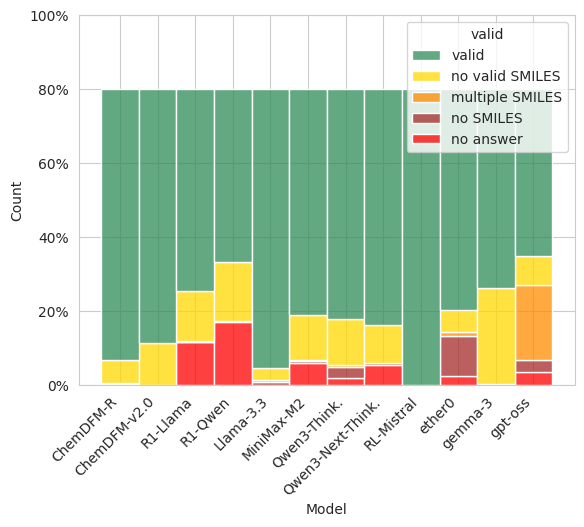

In [7]:
cmap = {
    "valid": "seagreen",
    "no valid SMILES": "gold",
    "multiple SMILES": "darkorange",
    "no SMILES": "brown",
    "no answer": "red"
}

ax = sns.histplot(data=df, x="Model", hue="valid", multiple="stack", stat="count", palette= cmap, hue_order=list(cmap.keys()))
# rotate x labels
max_count = 128_000
ax.set_ylim(0, max_count)

yticks = np.linspace(0, max_count, 6)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{int(y / max_count * 100)}%" for y in yticks])
_ = plt.xticks(rotation=45, ha='right')
# Replace y_ticks with percentages from 0 to 100

plt.savefig(f"{FIG_PATH}/validity.pdf", bbox_inches='tight')

# Rank Heatmaps

In [9]:
topk_dfs = []
ROLLOUTS_AT_K = {
    1: [5, 10, 50],
    5: [10, 25, 50],
    10: [25, 50, 100],
}
pbar = tqdm(total=sum([len(ROLLOUTS_AT_K[k]) for k in ROLLOUTS_AT_K]))

for k in tqdm(ROLLOUTS_AT_K):
    roll_values = ROLLOUTS_AT_K[k]
    stopk_dfs = []
    for r in roll_values:
        topdf = df[df.prompt_id.isin(sub_sample_prompts[:])].groupby(
            ["Model", "prompt_id"]
        ).apply(
            aggregate_molgen_fn("topk", k=k, n_rollout=r)
        ).to_frame().rename(columns={0:f"{r}"}).reset_index()
        stopk_dfs.append(
            topdf
        )
        pbar.update(1)
    topk_df = pd.concat(stopk_dfs).reset_index(drop=True)
    topk_df["k"] = k
    topk_df = topk_df.melt(id_vars=["prompt_id","Model", "k"], value_vars=[str(k) for k in roll_values], var_name="n_rollout", value_name= "top-k")
    topk_df["n_rollout"] = topk_df["n_rollout"].apply(int)
    topk_dfs.append(topk_df)

pbar.close()
topk_df = pd.concat(topk_dfs).reset_index(drop=True)
topk_df["rank"] = topk_df.groupby(["prompt_id", "k", "n_rollout"])["top-k"].rank(ascending=False)

100%|██████████| 9/9 [00:49<00:00,  5.52s/it]


In [10]:
def sort_prompt_ids(sub_df, y_order, r_max=2):
    x_order = []
    for model in y_order:
        first_rank = sub_df[(sub_df.Model == model) & (sub_df["rank"] == r_max-1)].prompt_id.tolist()
        # sort_first_rank = sub_df[(sub_df.Model == y_order[0]) & (sub_df.prompt_id.isin(first_rank))].sort_values(by="rank")
        # first_rank = sort_first_rank.prompt_id.tolist()
        x_order.append(first_rank)
        maybe_rank = sub_df[(sub_df.Model == model) & (sub_df["rank"] < r_max) & (sub_df["rank"] > r_max-1)]
        maybe_rank = [r for r in maybe_rank.prompt_id.tolist() if r not in x_order]
        x_order.append(maybe_rank)
    return x_order

def sort_recursive_prompts(sub_df, y_order, to_sort, r_max):
    if len(to_sort) <=1:
        return to_sort
    if r_max >= 8:
        return to_sort
    groups = sort_prompt_ids(sub_df, y_order, r_max=r_max)
    return sum(
        [sort_recursive_prompts(sub_df[sub_df.prompt_id.isin(g)], y_order, g, r_max +1) for g in groups],
        []
    )

100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


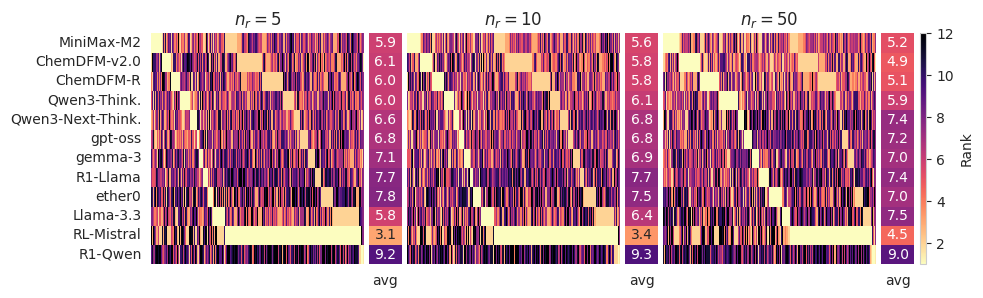

100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


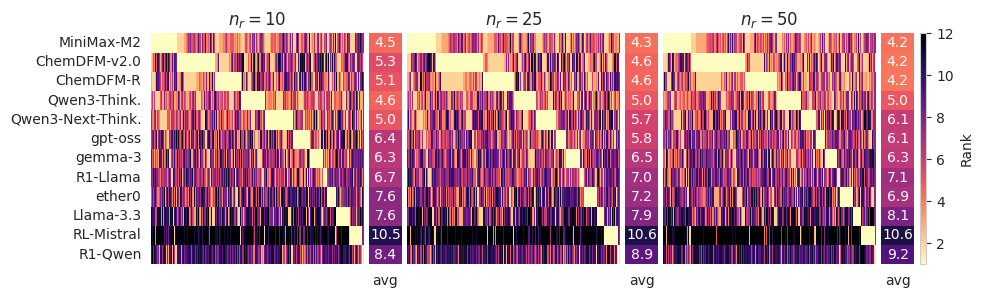

100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


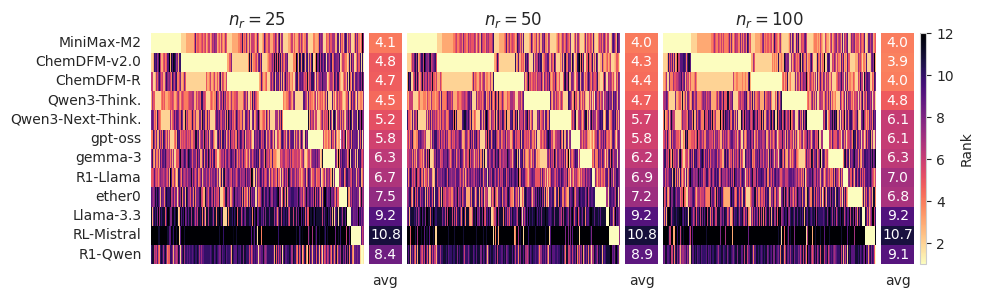

In [11]:
y_order = topk_df.groupby("Model")["rank"].mean().sort_values().index.tolist()

full_ratio = 3.2
avg_ratio = 0.5
cbar_ratio = 0.1

for k in ROLLOUTS_AT_K:
    roll_values = ROLLOUTS_AT_K[k]

    fig, axes_k = plt.subplots(1, 7, figsize=(10,3), gridspec_kw={"width_ratios":[full_ratio, avg_ratio] * len(roll_values) +[0.1], "wspace":0.05})

    for i_n,n_rolls in enumerate(tqdm(roll_values)):
        sub_df = topk_df[(topk_df.k == k) & (topk_df.n_rollout==n_rolls)]
        x_order = sort_recursive_prompts(sub_df, y_order, sub_df.prompt_id.unique().tolist(), r_max=2)
        heat_kwargs = {
            "cmap":"magma_r",
            "vmin":1,
            "vmax":len(y_order),
        }
        heatmap_df = sub_df.pivot_table(index="Model", columns=["prompt_id"], values="rank")
        heatmap_df = heatmap_df.reindex(index=y_order, columns=x_order)
        if i_n == 0:
            heat_kwargs["yticklabels"] = True
        else:
            heat_kwargs["yticklabels"] = False
        axes = axes_k[i_n*2:(i_n*2)+2 + int(i_n == len(roll_values) - 1)]

        sns.heatmap(heatmap_df, cbar=None, ax = axes[0], **heat_kwargs)
        sns.heatmap(heatmap_df.mean(1).to_frame(), cbar = None, ax = axes[1], annot = True, fmt=".1f", **heat_kwargs)

        axes[0].set_title(f"$n_r=${n_rolls}")
        for ax in axes:
            ax.set_xlabel("")
            ax.set_ylabel("")
            # remove xticks
        axes[0].set_xticks([])
        # set xtick label to "avg" for the second heatmap
        axes[1].set_xticks([0.5])
        axes[1].set_xticklabels(["avg"])
        axes[1].set_yticks([])

        # colorbar for the first heatmap in axes[2]
        if len(axes) == 3:
            cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="magma_r", norm=plt.Normalize(vmin=1, vmax=len(y_order))), cax=axes[2])
            cbar.set_label("Rank")
    os.makedirs(f"{FIG_PATH}/heatmap", exist_ok=True)
    plt.savefig(f"{FIG_PATH}/heatmap/topk_{k}_ranks_heatmap.pdf", bbox_inches='tight')
    plt.show()


# Uniqueness and Diversity Metrics

## Computations

Compute the uniqueness of the generated smiles in each prompt

In [12]:
uniq_df = df[df.validity == 1].groupby(["Model", "prompt_id"]).agg(
    **{f"{k}":pd.NamedAgg(column="smiles", aggfunc=aggregate_molgen_fn("uniqueness", k)) for k in list(range(1,100,10))}
).reset_index()
uniq_df = uniq_df.melt(id_vars=["Model"], value_vars=[str(k) for k in list(range(1,100,10))], var_name="n_rollout")
uniq_df["n_rollout"] = uniq_df["n_rollout"].apply(int)

Diversity in each prompt (ecfp4)

In [13]:
fp_fn = fp_name_to_fn("ecfp4-2048")
sub_df = df[
    (df.validity == 1) & (df.prompt_id.isin(sub_sample_prompts))
].drop_duplicates(subset=["prompt_id", "smiles"])
sub_df["fps"] = sub_df["smiles"].progress_apply(lambda x: fp_fn(Chem.MolFromSmiles(x)))

sim_df = sub_df.groupby(["Model", "prompt_id"]).agg(
    **{
        f"{k}":pd.NamedAgg(
            column="fps",
            aggfunc=aggregate_molgen_fn("diversity",k, is_fp=True))
        for k in [50]
    }
).reset_index()
sim_df = sim_df.melt(id_vars=["Model"], value_vars=[str(k) for k in [50]], var_name="n_rollout")
sim_df["n_rollout"] = sim_df["n_rollout"].apply(int)

100%|██████████| 699133/699133 [01:28<00:00, 7940.92it/s] 


Uniqueness accross prompts

In [25]:
uniqueness_ac_prompts = []

def topk_fn(k):
    def get_topk(x):
        return list(np.pad(x, (0, 100), 'constant', constant_values=None)[:k])
    return get_topk

def avg_prompt_occurrence(smiles_lists):
    n_prompts = len(smiles_lists)
    if n_prompts == 0:
        return np.nan

    # Count in how many prompts each SMILES appears
    smiles_prompt_counts = {}
    for smiles_list in smiles_lists:
        # Get unique SMILES in this prompt (avoid counting duplicates within same prompt)
        unique_in_prompt = set(s for s in smiles_list if s is not None)
        for smi in unique_in_prompt:
            smiles_prompt_counts[smi] = smiles_prompt_counts.get(smi, 0) + 1

    if len(smiles_prompt_counts) == 0:
        return np.nan

    # Calculate the proportion of prompts each SMILES appears in
    proportions = [count for count in smiles_prompt_counts.values()]

    # Return the average proportion
    return np.mean(proportions)

for k in tqdm(range(2,101,10)):
    smiles_per_p = df[df.validity == 1].groupby(
        ["Model", "prompt_id"]
    ).smiles.apply(topk_fn(k)).reset_index()

    uniqueness_ac_prompts.append(
        smiles_per_p.groupby("Model").smiles.apply(
            avg_prompt_occurrence
        ).reset_index().rename(columns={"smiles":str(k)})
    )

uniq_ap_df = pd.concat(
    [sdf.set_index("Model") for sdf in uniqueness_ac_prompts], axis = 1
).reset_index().melt(id_vars=["Model"], value_vars=[str(k) for k in range(2,101,10)], var_name="n_rollout")
uniq_ap_df["n_rollout"] = uniq_ap_df["n_rollout"].apply(int)

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


## Plots

In [26]:
from notebooks.utils import CMAP_MODELS

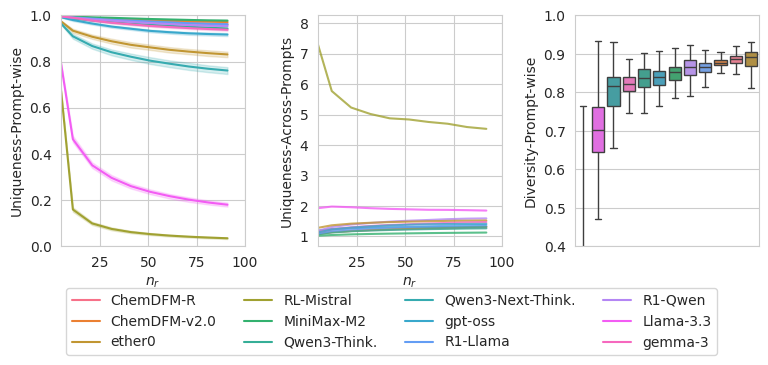

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(9,3), sharey=False, gridspec_kw={"wspace":0.4})

ax = axes[0]
sns.lineplot(uniq_df, x="n_rollout", y="value", hue="Model", ax=ax, legend=True, palette=CMAP_MODELS, hue_order=CMAP_MODELS.keys())
ax.set_ylabel("Uniqueness-Prompt-wise")
ax.set_xlabel("$n_r$")
ax.set_ylim(0,1)
ax.set_xlim(5,100)
# Move legend below plot
ax.legend(bbox_to_anchor=(1.8, -.5), loc='lower center', ncols=4)

ax = axes[1]
sns.lineplot(uniq_ap_df, x="n_rollout", y="value", hue="Model", ax=ax, legend = False, palette=CMAP_MODELS, alpha=0.8)
ax.set_ylabel("Uniqueness-Across-Prompts")
# ax.set_ylim(0.,1)
ax.set_xlim(5,100)
ax.set_xlabel("$n_r$")

ax = axes[2]
x_order = sim_df.groupby("Model")["value"].median().sort_values().index.tolist()
sns.boxplot(sim_df, x="Model", y="value", hue="Model", ax=ax, legend = False, order=x_order, palette=CMAP_MODELS,fliersize=0)
ax.set_ylabel("Diversity-Prompt-wise")
ax.set_xlabel("")
ax.set_xticklabels([],)
ax.set(ylim=(0.4,1))

fig.savefig(f"{FIG_PATH}/uniqueness_diversity.pdf", bbox_inches='tight')

# Top-k scores

In [28]:
k_values = [1,5,10,20,30]
topk_dfs = []
pbar = tqdm(total=sum([len(range(k+1,101,10)) for k in k_values]))

for k in k_values:
    roll_values = list(range(k+1,101,10))
    k_topk_dfs = []
    for roll in roll_values:
        topdf = df[df.prompt_id.isin(sub_sample_prompts[:])].groupby(
            ["Model", "prompt_id"]
        ).apply(
            aggregate_molgen_fn("topk", k=k, n_rollout=roll)
        ).to_frame().rename(columns={0:f"{roll}"}).reset_index()
        k_topk_dfs.append(
            topdf
        )
        pbar.update(1)

    topk_df = pd.concat(k_topk_dfs).reset_index(drop=True)
    topk_df["k"] = k
    topk_df = topk_df.melt(id_vars=["prompt_id","Model", "k"], value_vars=[str(k) for k in roll_values], var_name="n_rollout", value_name= "top-k")
    topk_df["n_rollout"] = topk_df["n_rollout"].apply(int)

    topk_dfs.append(topk_df)
pbar.close()
topk_df = pd.concat(topk_dfs).reset_index(drop=True)

100%|██████████| 44/44 [04:01<00:00,  5.50s/it]


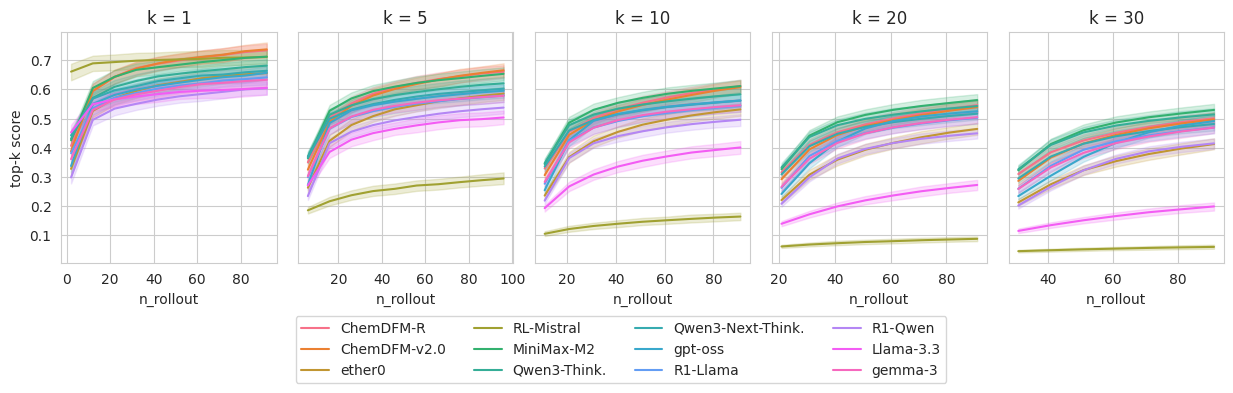

In [29]:
fig,axes = plt.subplots(
    1,
    topk_df.k.nunique(),
    figsize=(3 * topk_df.k.nunique(),3),
    sharey=True,
    gridspec_kw={"wspace":0.1 }
)

for k, ax in zip(topk_df.k.unique(), axes):
    sns.lineplot(topk_df[
         topk_df.k == k
     ], x="n_rollout", y="top-k", hue="Model", ax=ax, legend = k==30, palette=CMAP_MODELS, hue_order=CMAP_MODELS.keys())
    ax.set_ylabel("top-k score")
    ax.set_title(f"k = {k}")
# Move legend of the last axis below plot
axes[-1].legend(bbox_to_anchor=(-1.8, -0.55), loc='lower center', ncols=4)

fig.savefig(f"{FIG_PATH}/topk_k_score.pdf", bbox_inches='tight')

# Tables for Top-k

In [30]:
from notebooks.metadata.molgen import MODEL_META

In [38]:
# Create table with: model_name, size, metric_name, value
import re

ROLLOUTS_AT_K = {
    1: [3, 5, 10,],
    5: [10, 25, 50],
    10: [25, 50, 100],
}

table = pd.DataFrame(columns=["model", "Size", "Think.", "Metric", r"$n_\text{rollouts}$", "Value"])
size_pattern = re.compile(r'(?i)(?:^|[-_])(\d+\s*[b])(?:$|[-_])')
pbar = tqdm(total=len(df.model.unique())*sum([len(ROLLOUTS_AT_K[k]) for k in ROLLOUTS_AT_K]))

for model_name in df.model.unique():
    assert any([m in model_name for m in MODEL_META.keys()]), f"Model {model_name} not found in MODEL_META"
    key = [m for m in MODEL_META.keys() if m in model_name][0]
    metadata = MODEL_META[key]
    for k in ROLLOUTS_AT_K:
        for n_rollout in ROLLOUTS_AT_K[k]:
            sub_df = df[df.model == model_name]
            sub_df = sub_df.drop_duplicates(subset=["prompt_id", "smiles"])
            pass_k = sub_df.groupby("prompt_id").apply(
                aggregate_molgen_fn("topk",k=k, n_rollout=n_rollout)
            ).to_frame().rename(columns={0:str(k)}).reset_index()
            if not "size" in metadata:
                try:
                    size = size_pattern.search(model_name).group(1).upper()
                except:
                    raise ValueError(f"Size not found for model {model_name}")
            else:
                size = metadata["size"]
            for i, row in pass_k.iterrows():
                thinking = r"\CheckmarkBold" if metadata["thinking"] else r"\XSolidBrush"
                chem = r"\CheckmarkBold" if metadata["Chem."] else r"\XSolidBrush"

                table.loc[len(table)] = [
                    model_name,
                    size,
                    thinking,
                    # chem,
                    f"top-{k}, $n_r$:",
                    n_rollout,
                    row[str(k)]
                ]
            pbar.update(1)


100%|██████████| 108/108 [03:43<00:00,  3.40s/it]

In [39]:
from notebooks.utils.utils import process_model_name

table["Model"] = table["model"].apply(lambda x: re.sub(r"-\d+(B|b)", "", x).replace("-2507", "").replace("-A3B", "").replace("-Distill", "").replace("-it", "").replace("Thinking", "Think.").replace("DeepSeek-", "").replace("-Instruct", ""))

MODEL_ORDER = [
    "MiniMax-M2",
    "Qwen3-Think.",
    "Qwen3-Next-Think.",
    "gpt-oss",
    "R1-Llama",
    "R1-Qwen",
    "gemma-3",
    "Llama-3.3",
    "RL-Mistral",
    "ChemDFM-R",
    "ether0",
    "ChemDFM-v2.0",
]

table["N_rolls"] = table[r"$n_\text{rollouts}$"].apply(lambda x: str(x))
table["Model"] = table["Model"].apply(lambda x: x.replace("_", ""))


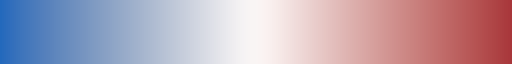

In [40]:
LATEX_PATH = "MolGenDocking-latex/tables"
cmap = sns.color_palette("vlag", as_cmap=True)
cmap

In [53]:
from notebooks.utils import PandasTableFormatter

def color_map(val: float) -> str:
    "Returns a color based on the value (eg '#FF5733')"
    color = cmap(val)
    return f"rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})"

formatter = PandasTableFormatter(
    n_decimals = 3, # Number of decimals to keep in the table
    aggregation_methods=["mean"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False, # Whether to compute global aggregation across all columns (True)
    color_mapping =color_map
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", "Size", "Think."], # Rows
    cols=["Metric", r"N_rolls"], # Columns
    values= "Value", # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["textbf:--rwrap--latex; underline:--rwrap--latex", "underline:--rwrap--latex", "underline:--rwrap--latex",], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=True,
    row_order = MODEL_ORDER
)
formatter.save_to_latex(
    style, f"{LATEX_PATH}/gen_table.tex", 0, multicol_align="|c|", hrules=True,
)
style

In [42]:
formatter = PandasTableFormatter(
    n_decimals = 3, # Number of decimals to keep in the table
    aggregation_methods=["mean", "std"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False # Whether to compute global aggregation across all columns (True)
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", "Size", "Think."], # Rows
    cols=["Metric", r"N_rolls"], # Columns
    values= "Value", # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["font-weight: bold; text-decoration: underline;", "text-decoration: underline;"], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=True,
    row_order = MODEL_ORDER
)
formatter.save_to_latex(style, f"{LATEX_PATH}/gen_table_std.tex", 1, multicol_align="|c|", hrules=True, n_first_cols=2)

Model
Size
Think.
